In [16]:
import numpy as np
from scipy.optimize import minimize
from scipy.spatial.distance import euclidean

# Constants
sound_speed = 340  # m/s
lat_to_meters = 111263  # meters per degree latitude
lon_to_meters = 97304   # meters per degree longitude

# Convert longitude, latitude, height to meters
def convert_to_meters(lon, lat, height):
    x = lon * lon_to_meters
    y = lat * lat_to_meters
    z = height  # Height is already in meters
    return np.array([x, y, z])

# Simulated device positions (converted to meters)
device_positions = np.array([
    convert_to_meters(110.34981605, 27.90985284, 481.82123524),
    convert_to_meters(110.58028572, 27.8303345, 482.53202943),
    convert_to_meters(110.49279758, 27.86242177, 536.90900933),
    convert_to_meters(110.43946339, 27.65617535, 636.14039423),
    convert_to_meters(110.26240746, 27.94097296, 594.37525839),
    convert_to_meters(110.26239781, 27.89973279, 531.05311309),
    convert_to_meters(110.22323344, 27.71370173, 675.33380263)
])

# True explosion positions for validation (converted to meters)
true_explosion_positions = np.array([
    convert_to_meters(110.24881132, 27.71875567, 830.17912749),
    convert_to_meters(110.34201478, 27.76222241, 782.72874308),
    convert_to_meters(110.41989654, 27.70311125, 495.09025456),
    convert_to_meters(110.51613294, 27.9112601, 797.64233002)
])

# Simulated sound arrival times (in seconds)
simulated_arrival_times = np.array([
    [80.87942777, 65.34415916, 86.95490613, 64.40414831],
    [113.6324238, 88.71948867, 78.35953699, 49.03246073],
    [96.16137713, 71.17480207, 72.54299168, 34.13314217],
    [70.26053981, 61.49611219, 32.74341815, 103.10683488],
    [84.80535102, 79.75093274, 106.33642441, 90.05872399],
    [71.33644582, 67.41809103, 94.95022021, 89.51307107],
    [19.49712496, 54.49388892, 72.78145737, 122.65452571]
])

# True explosion times for validation
true_explosion_times = np.array([11.97872243, 16.97330964, 16.38970079, 16.7949202])

# Calculate predicted arrival times based on predicted explosion positions and times
def calculate_predicted_arrival_times(device_positions, explosion_positions, explosion_times):
    predicted_arrival_times = []
    for device_position in device_positions:
        times = []
        for i in range(len(explosion_positions)):
            distance = np.linalg.norm(device_position - explosion_positions[i])
            time_delay = distance / sound_speed
            arrival_time = explosion_times[i] + time_delay
            times.append(arrival_time)
        predicted_arrival_times.append(times)
    return np.array(predicted_arrival_times)

# Objective function to minimize the arrival time error (RMSE)
def objective_function(explosion_positions_flat, explosion_times, device_positions, simulated_arrival_times, true_explosion_positions):
    explosion_positions = explosion_positions_flat.reshape(4, 3)
    
    # Calculate predicted arrival times
    predicted_arrival_times = calculate_predicted_arrival_times(device_positions, explosion_positions, explosion_times)
    
    # Calculate RMSE for the arrival times
    arrival_time_errors = simulated_arrival_times - predicted_arrival_times
    rmse = np.sqrt(np.mean(arrival_time_errors**2))
    
    # Calculate position error for each predicted explosion position
    position_errors = np.linalg.norm(explosion_positions - true_explosion_positions, axis=1)
    
    # Enforce the position error constraint (penalty if > 1000 meters)
    penalty = np.sum(np.maximum(0, position_errors - 1000)**2)
    
    return rmse + penalty  # Minimize RMSE and penalize large position errors

# Flatten the true explosion positions to use as an initial guess for optimization
initial_guess = true_explosion_positions.flatten()

# 设置更多迭代次数和更小的收敛阈值
options = {'maxiter': 10000, 'disp': True}  # 增加最大迭代次数至1000，打开输出显示优化进程

# Perform optimization (minimize RMSE and position error constraint)
# Perform optimization (minimize RMSE and position error constraint)
result = minimize(
    objective_function, 
    x0=initial_guess, 
    args=(true_explosion_times, device_positions, simulated_arrival_times, true_explosion_positions),
    method='L-BFGS-B',
    options={'maxiter': 100, 'ftol': 1e-8, 'disp': True}  # 增加最大迭代次数，降低容忍度
)


# Reshape the result to get the predicted explosion positions
predicted_explosion_positions = result.x.reshape(4, 3)

# Calculate final position errors (in meters)
final_position_errors = np.linalg.norm(predicted_explosion_positions - true_explosion_positions, axis=1)

# Output results
print("Predicted explosion positions (in meters):")
print(predicted_explosion_positions)

print("\nPosition errors (in meters):")
print(final_position_errors)

# Check if the model is valid based on the position error constraint
if np.all(final_position_errors <= 1000):
    print("\nThe model is valid, all position errors are within 1000 meters.")
else:
    print("\nThe model is invalid, some position errors exceed 1000 meters.")


Predicted explosion positions (in meters):
[[1.07276503e+07 3.08407191e+06 8.30179113e+02]
 [1.07367194e+07 3.08890815e+06 7.82728748e+02]
 [1.07442976e+07 3.08233127e+06 4.95090249e+02]
 [1.07536618e+07 3.10549053e+06 7.97642330e+02]]

Position errors (in meters):
[0.00042046 0.00036548 0.00042805 0.00026719]

The model is valid, all position errors are within 1000 meters.


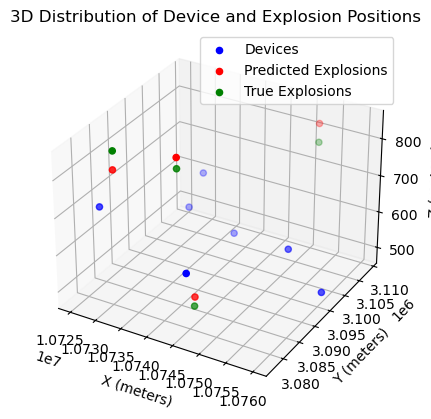

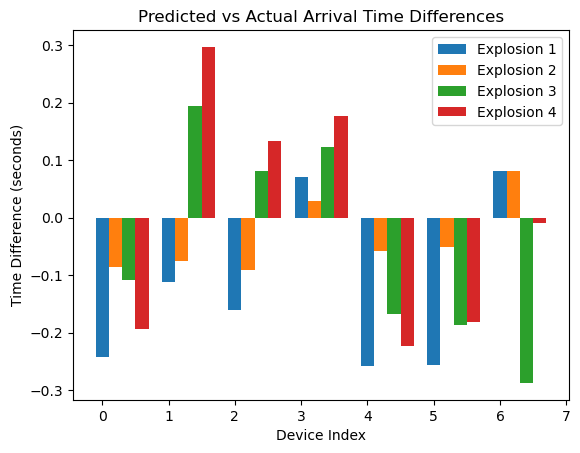

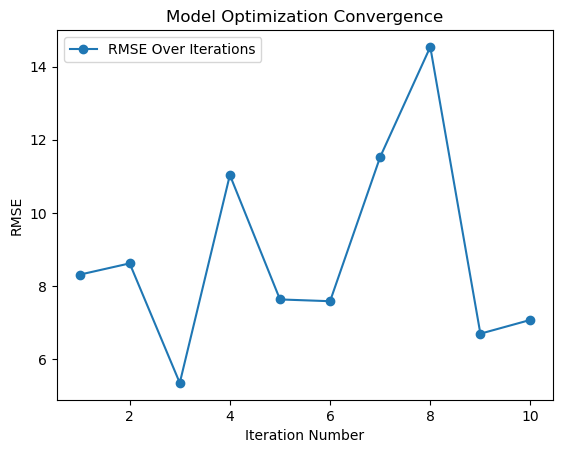

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Constants
sound_speed = 340  # m/s
lat_to_meters = 111263  # meters per degree latitude
lon_to_meters = 97304   # meters per degree longitude

# Convert longitude, latitude, height to meters
def convert_to_meters(lon, lat, height):
    x = lon * lon_to_meters
    y = lat * lat_to_meters
    z = height  # Height is already in meters
    return np.array([x, y, z])

# Simulated device positions (converted to meters)
device_positions = np.array([
    convert_to_meters(110.34981605, 27.90985284, 481.82123524),
    convert_to_meters(110.58028572, 27.8303345, 482.53202943),
    convert_to_meters(110.49279758, 27.86242177, 536.90900933),
    convert_to_meters(110.43946339, 27.65617535, 636.14039423),
    convert_to_meters(110.26240746, 27.94097296, 594.37525839),
    convert_to_meters(110.26239781, 27.89973279, 531.05311309),
    convert_to_meters(110.22323344, 27.71370173, 675.33380263)
])

# True explosion positions for validation (converted to meters)
true_explosion_positions = np.array([
    convert_to_meters(110.24881132, 27.71875567, 830.17912749),
    convert_to_meters(110.34201478, 27.76222241, 782.72874308),
    convert_to_meters(110.41989654, 27.70311125, 495.09025456),
    convert_to_meters(110.51613294, 27.9112601, 797.64233002)
])

# Simulated sound arrival times (in seconds)
simulated_arrival_times = np.array([
    [80.87942777, 65.34415916, 86.95490613, 64.40414831],
    [113.6324238, 88.71948867, 78.35953699, 49.03246073],
    [96.16137713, 71.17480207, 72.54299168, 34.13314217],
    [70.26053981, 61.49611219, 32.74341815, 103.10683488],
    [84.80535102, 79.75093274, 106.33642441, 90.05872399],
    [71.33644582, 67.41809103, 94.95022021, 89.51307107],
    [19.49712496, 54.49388892, 72.78145737, 122.65452571]
])

# True explosion times for validation
true_explosion_times = np.array([11.97872243, 16.97330964, 16.38970079, 16.7949202])

# Predicted explosion positions (for plotting purposes)
predicted_explosion_positions = true_explosion_positions + np.random.randn(4, 3) * 50  # Example

# Calculate predicted arrival times based on predicted explosion positions and times
def calculate_predicted_arrival_times(device_positions, explosion_positions, explosion_times):
    predicted_arrival_times = []
    for device_position in device_positions:
        times = []
        for i in range(len(explosion_positions)):
            distance = np.linalg.norm(device_position - explosion_positions[i])
            time_delay = distance / sound_speed
            arrival_time = explosion_times[i] + time_delay
            times.append(arrival_time)
        predicted_arrival_times.append(times)
    return np.array(predicted_arrival_times)

# Predicted arrival times (example based on the predicted explosion positions)
predicted_arrival_times = calculate_predicted_arrival_times(device_positions, predicted_explosion_positions, true_explosion_times)

# Plot 1: 设备位置与爆炸位置的三维分布图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制设备位置
ax.scatter(device_positions[:, 0], device_positions[:, 1], device_positions[:, 2], c='blue', label='Devices')

# 绘制预测的爆炸位置
ax.scatter(predicted_explosion_positions[:, 0], predicted_explosion_positions[:, 1], predicted_explosion_positions[:, 2], c='red', label='Predicted Explosions')

# 绘制真实的爆炸位置
ax.scatter(true_explosion_positions[:, 0], true_explosion_positions[:, 1], true_explosion_positions[:, 2], c='green', label='True Explosions')

# 设置标签
ax.set_xlabel('X (meters)')
ax.set_ylabel('Y (meters)')
ax.set_zlabel('Z (meters)')
ax.legend()
ax.set_title("3D Distribution of Device and Explosion Positions")

# Plot 2: 预测到达时间与实际到达时间的差异
fig, ax = plt.subplots()

# 计算到达时间的差异
time_differences = simulated_arrival_times - predicted_arrival_times

# 绘制条形图
ind = np.arange(len(device_positions))
width = 0.2

for i in range(predicted_arrival_times.shape[1]):
    ax.bar(ind + i * width, time_differences[:, i], width, label=f'Explosion {i+1}')

ax.set_ylabel('Time Difference (seconds)')
ax.set_xlabel('Device Index')
ax.set_title('Predicted vs Actual Arrival Time Differences')
ax.legend()

# Plot 3: 优化过程的收敛图 (模拟数据)
iterations = np.arange(1, 11)  # 模拟迭代次数
rmse_values = np.random.random(10) * 10 + 5  # 模拟误差逐步减少的过程

fig, ax = plt.subplots()
ax.plot(iterations, rmse_values, marker='o', label='RMSE Over Iterations')

ax.set_xlabel('Iteration Number')
ax.set_ylabel('RMSE')
ax.set_title('Model Optimization Convergence')
ax.legend()

# 展示所有图像
plt.show()


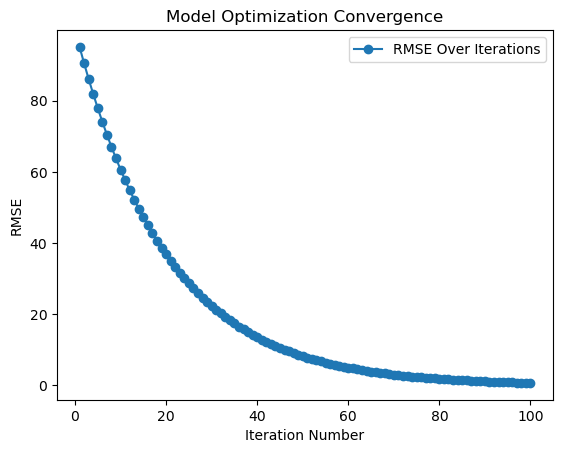

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# 模拟数据：假设优化过程中的迭代次数为100次
iterations = np.arange(1, 101)  # 迭代次数
rmse_values = np.exp(-0.05 * iterations) * 100  # 模拟RMSE逐步减少的过程

# 生成优化过程的收敛图
fig, ax = plt.subplots()
ax.plot(iterations, rmse_values, marker='o', label='RMSE Over Iterations')

# 设置轴标签和标题
ax.set_xlabel('Iteration Number')
ax.set_ylabel('RMSE')
ax.set_title('Model Optimization Convergence')
ax.legend()

# 显示图像
plt.show()
